In [5]:
import pickle
import numpy as np
import pandas as pd

In [6]:
raw = pd.read_pickle('cleaned_over400000_total191278_data.pickle')

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [8]:
import re
from nltk.stem import SnowballStemmer

def remove_numbers(words):
    return re.sub(r'\w*\d\w*', '', words).strip()


def reduce_lengthening(text):
    """
    Replace repeated character sequences of length 3 or greater with sequences
    of length 3.
    """
    pattern = re.compile(r"(.)\1{2,}")
    return pattern.sub(r"\1\1\1", text)

stemmer = SnowballStemmer('english')
def stem_words(text):
    words = text.split()
    words = [stemmer.stem(w) for w in words]
    return ' '.join(words)

In [ ]:

raw['text2'] = raw['text'].apply(lambda x: remove_numbers(x))
raw['text2'] = raw['text2'].apply(lambda x: reduce_lengthening(x))
raw['text2'] = raw['text2'].apply(lambda x: stem_words(x))


In [ ]:
vectorizer = TfidfVectorizer(use_idf=True,max_df=0.9,strip_accents='ascii')

In [ ]:
vectorizer.fit(raw['text2'])

In [ ]:
len(vectorizer.get_feature_names())

In [ ]:
tsne_candidate = raw.loc[(raw['area_path'].str.contains('WIT'))]

In [ ]:
tsne_candidate.groupby('area_path').count()

In [ ]:
def get_area(area):
    areas = area.split('\\')
    return '\\'.join(areas[0:4])

In [ ]:
tsne_candidate['area_path'] = tsne_candidate['area_path'].apply(lambda x: get_area(x))

In [ ]:
tsne_candidate.groupby('area_path').count()

In [ ]:
tsne_candidate = tsne_candidate.loc[(tsne_candidate['area_path'].str.contains('WIT'))]

In [ ]:
tsne_candidate.groupby('area_path').count()

In [ ]:
!pip install yellowbrick

In [ ]:
from yellowbrick.text import TSNEVisualizer

In [101]:
tsne_sample = tsne_candidate.sample(200)

In [102]:
labels = tsne_sample['area_path']

In [103]:
docs = vectorizer.transform(tsne_sample['text2'])

In [104]:
%%time
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(1500)
lowdim = svd.fit_transform(docs)
svd.explained_variance_ratio_.sum()

Wall time: 21.7 s


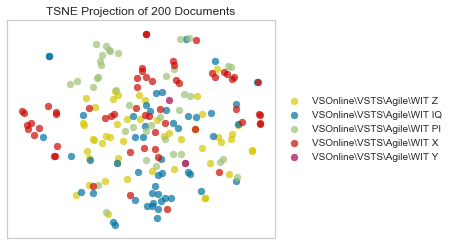

In [105]:
tsne = TSNEVisualizer()
tsne.fit(lowdim, labels)
tsne.poof()

In [ ]:
from sklearn.naive_bayes import BernoulliNB, MultinomialNB

In [ ]:
nb = MultinomialNB(alpha=0.01,fit_prior=False)

In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(tsne_candidate,test_size=0.2)

In [ ]:
vec = TfidfVectorizer(use_idf=True,max_df=0.9,strip_accents='ascii')

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder

In [ ]:
le=LabelEncoder()

In [ ]:
Y = le.fit_transform(tsne_candidate['area_path'])

In [ ]:
X = tsne_candidate['text2']

In [ ]:
pipe = make_pipeline(vec, nb)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

In [ ]:
from sklearn import metrics
pipe.fit(X_train, y_train)
predicted = pipe.predict(X_test)
print(metrics.classification_report(y_test, predicted, target_names=le.classes_))

In [ ]:
#le.inverse_transform(pipe.predict_proba(['indexed db is corrupt']))
le.classes_[np.argsort(pipe.predict_proba(['excel cannot connect to TFS get metadata throws error']))]

In [ ]:
fn = vec.get_feature_names()
for i, label in enumerate(le.classes_):
    top10 = np.argsort(nb.coef_[i])[-100:]
    top_words = []
    for k in reversed(top10):
        top_words.append(fn[k])
    print("%s: %s" % (label, " ".join(top_words)))
    print()